In [2]:
import author
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns
from sklearn.linear_model import Ridge, Lasso, ElasticNet
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
import sys
sys.path.insert(0, "/Users/jin/Programming/Machine_Learning/All-about-Market/trading/Jeong/machine_trade/code")
import eval_model
engine = author.processed_engine
raw_engine = author.raw_engine

각 종목 별로 유의미한 피쳐들을 선정해 사용한다. </br>
* BTC: Macd_signal, Vwap, Pct, Macd_Gap, Moment, Fast_d, Rsi
* TLT: Macd_signal, Vwap, Pct, Macd_Gap, Moment, Fast_d
* QQQ: Macd_signal, Vwap, pct, Moment, Rsi, Macd_Gap
* GCF: Macd_signal, Vwap, pct, Moment

* Vix나 USDT 같은 지표 들은 그냥 값을 그대로 활용했다. 부가적인 요소들을 사용하지 않았다.

In [3]:
def get_df(ticker):
    df = pd.read_sql(f"SELECT * FROM {ticker}_1d",engine) #로컬 db에서 테이블 가져옴
    df.set_index(df.columns[0], inplace=True)
    return df

bit_df = get_df("BTCUSD")
qqq_df = get_df("QQQ")
tlt_df = get_df("TLT")
gld_df = get_df("GCF")


비트코인의 데이터 만으로 가격을 예측 할 수 있을까? </br>
비트코인은 다른 자산과의 상관관계도 높은 편이고 과적합을 피하기 위해서라도 다른 자산의 피쳐를 활용하는 것은 </br>
현명한 생각으로 보여진다.

In [4]:
bit_fedf = bit_df[["Macd_Signal", "Vwap", "Pct", "Moment", "Fast_d", "Rsi","Price"]]
tlt_fedf = tlt_df[["Moment"]]
qqq_fedf = qqq_df[["Moment"]]
gld_fedf = gld_df[["Moment"]]

금, 미국 장기채, 나스닥, 금선물의 추세지표를 가져온다.

In [5]:
vix = pd.read_sql("SELECT Date, Close FROM VIX_1d", raw_engine)
vix.set_index(vix.columns[0], inplace=True)
usd = pd.read_sql("SELECT Date, Close FROM DXF_1d", raw_engine)
usd.set_index(usd.columns[0], inplace=True)


VIX(변동성 지표)와 달러 인덱스도 가져온다.

In [6]:
data_frames = [bit_fedf, tlt_fedf, qqq_fedf, gld_fedf, vix, usd]
for df, ticker in zip(data_frames, ["BTC","TLT","QQQ","GCF","VIX","USD"]):
    df.columns = [f"{ticker}_{c}" for c in df.columns]
    print(df.index[0])


2015-02-28 00:00:00
2015-09-17 00:00:00
2015-09-17 00:00:00
2015-11-11 00:00:00
2015-02-27 00:00:00
2015-02-27 00:00:00


In [7]:
from functools import reduce
df_merged = reduce(lambda left,right: pd.merge(left, right, right_index=True, left_index=True,
                                            how='outer'), data_frames)

df_merged

,BTC_Macd_Signal,BTC_Vwap,BTC_Pct,BTC_Moment,BTC_Fast_d,BTC_Rsi,BTC_Price,TLT_Moment,QQQ_Moment,GCF_Moment,VIX_Close,USD_Close
2015-02-27,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,13.340000,95.320999
2015-02-28,2.738,240.599,0.171,0.916,17.051,58.802,254.263,NaN,NaN,NaN,NaN,NaN
2015-03-01,3.969,240.808,2.336,0.930,25.940,61.534,260.202,NaN,NaN,NaN,NaN,NaN
2015-03-02,6.123,241.435,5.945,0.965,30.447,67.566,275.670,NaN,NaN,NaN,13.040000,95.478996
2015-03-03,8.221,242.400,2.188,0.980,28.741,69.571,281.702,NaN,NaN,NaN,13.860000,95.407997
...,...,...,...,...,...,...,...,...,...,...,...,...
2022-05-04,-943.277,27887.285,5.160,61.846,17.622,48.366,39698.371,1.028,2.231,1.302,25.420000,102.594002
2022-05-05,-1073.475,27897.073,-7.867,61.371,16.616,38.143,36575.141,1.015,2.205,1.304,31.200001,103.802002
2022-05-06,-1205.865,27904.415,-1.461,60.949,14.637,36.714,36040.922,1.008,2.196,1.307,30.190001,103.680000
2022-05-07,-1338.842,27908.839,-1.495,60.490,12.998,35.278,35501.953,NaN,NaN,NaN,NaN,NaN


In [8]:
df_merged = df_merged.fillna(method='bfill').dropna()
test_df, df_merged = df_merged[-100:], df_merged[:-100]

<AxesSubplot:>

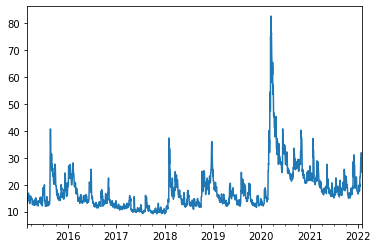

In [9]:
df_merged['VIX_Close'].plot()

모델을 학습 시켜보자. 자산을 추가함으로써 내가 얻고 싶은 것들은 아래와 같다.
* 모델의 과적합 해소
* 모델이 폭락, 폭등에 조금이나마 적응
* 특정 기간에만 잘 맞는 현상 제거

In [10]:
ridge_model = Pipeline([
    ("poly_features",PolynomialFeatures(degree=1, include_bias=False)),
    ('min_max', MinMaxScaler()),
    ('regulator', Ridge(alpha=1,solver="cholesky",random_state=42,fit_intercept=True))
])

lasso_model = Pipeline([
    ("poly_features",PolynomialFeatures(degree=1, include_bias=True)),
    ('min_max', MinMaxScaler()),
    ('regulator', Lasso(alpha=1,random_state=42,fit_intercept=True))
])

elastic_model = Pipeline([
    ("poly_features",PolynomialFeatures(degree=1, include_bias=True)),
    ('min_max', MinMaxScaler()),
    ('regulator', ElasticNet(alpha=1,random_state=42,fit_intercept=True,l1_ratio=0.7))
])

rf_model = Pipeline([
    ('min_max',MinMaxScaler()),
    ('machine',RandomForestRegressor(bootstrap=True, random_state=42, oob_score=True, max_depth=2000))
])

In [11]:
def create_train_data(df):
    """ 트레이닝 데이터를 생성한다. 
        다음날 데이터를 예측 해야 하므로 한 칸씩 미뤄주고 댕겨준다.
    """
    X = df.drop(['BTC_Price'], axis=1).iloc[:-1]
    y = df['BTC_Price'].iloc[1:]
    train_X, test_X, train_y, test_y = train_test_split(X, y, test_size=0.3, random_state=42)
    return train_X, test_X, train_y, test_y

In [12]:
train_X, test_X, train_y, test_y = create_train_data(df_merged)
ridge_model.fit(train_X, train_y)
lasso_model.fit(train_X, train_y)
elastic_model.fit(train_X, train_y)
rf_model.fit(train_X, train_y)

Pipeline(steps=[('min_max', MinMaxScaler()),
                ('machine',
                 RandomForestRegressor(max_depth=2000, oob_score=True,
                                       random_state=42))])

In [13]:
def plot_coef(coef, index, intercept=False):
    if intercept:
        index = index.insert(0, "Intercept")
    coef_df = pd.DataFrame(data=coef,index=index,columns=["Coef"])
    coef_df.plot.bar(figsize=(12,8))

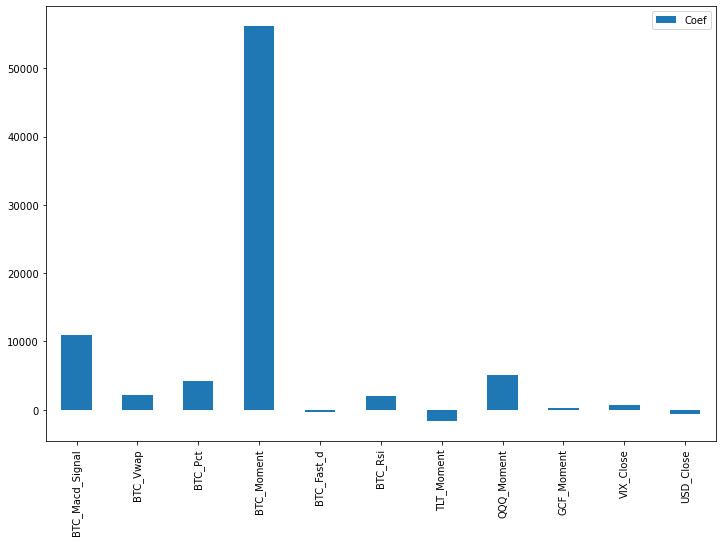

In [14]:
plot_coef(ridge_model['regulator'].coef_, train_X.columns)

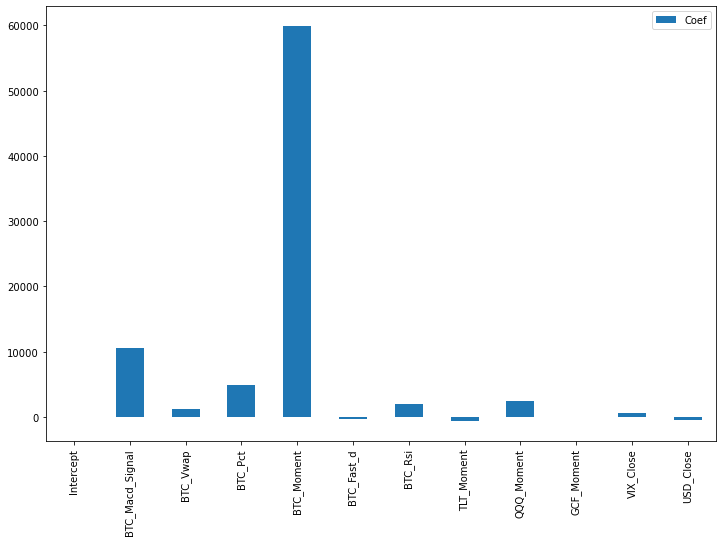

In [15]:
plot_coef(lasso_model['regulator'].coef_, train_X.columns,True)

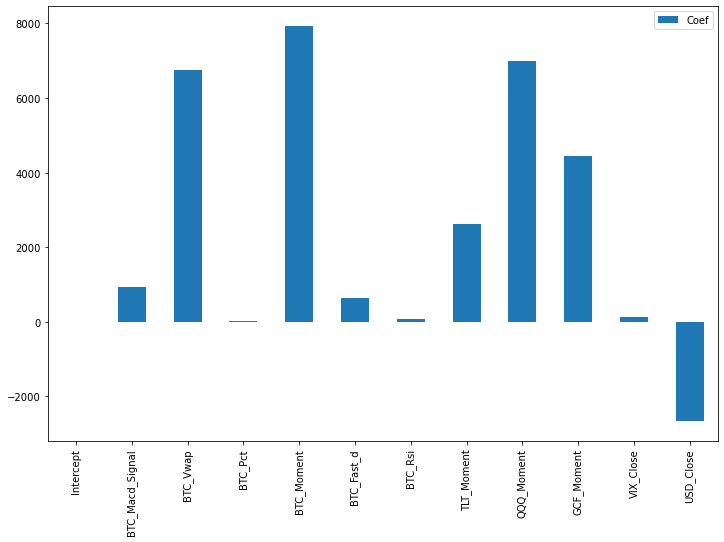

In [16]:
plot_coef(elastic_model['regulator'].coef_, train_X.columns, True)


In [17]:
def find_best_alpha(train_X, train_y, test_X, test_y, model):
    """파라미터 값을 변경해가며 알파 값을 바꿔본다."""
    best_alpha = 1
    best_mse = float('inf')
    for i in [1000,300,100,30,10,1,0.1,0.03,0.01,0.001]:
        model.set_params(regulator__alpha=i)
        model.fit(train_X, train_y)
        pred = model.predict(test_X)
        mse = ((test_y - pred) ** 2).mean()
        if best_mse > mse:
            best_mse = mse
            best_alpha = i
        print(f'mse: {mse}, alpha: {i}')
    return best_alpha

ridge_model.set_params(poly_features__degree=3)
r_alpha = find_best_alpha(train_X, train_y, test_X, test_y, ridge_model)
ridge_model.set_params(regulator__alpha=r_alpha)
ridge_model.fit(train_X, train_y)

lasso_model.set_params(poly_features__degree=3)
l_alpha = find_best_alpha(train_X, train_y, test_X, test_y, lasso_model)
lasso_model.set_params(regulator__alpha=l_alpha)
lasso_model.fit(train_X, train_y)

elastic_model.set_params(poly_features__degree=3)
e_alpha = find_best_alpha(train_X, train_y, test_X, test_y, elastic_model)
elastic_model.set_params(regulator__alpha=e_alpha)
elastic_model.fit(train_X, train_y)



mse: 8249252.657003091, alpha: 1000
mse: 3614094.235096012, alpha: 300
mse: 2330416.9806309473, alpha: 100
mse: 1589854.7053511513, alpha: 30
mse: 1151860.9697930983, alpha: 10
mse: 815757.9427115509, alpha: 1
mse: 781351.4635477903, alpha: 0.1
mse: 786913.4142601168, alpha: 0.03
mse: 803398.4635134857, alpha: 0.01
mse: 845151.799187909, alpha: 0.001
mse: 17668345.968802314, alpha: 1000
mse: 4374124.161472105, alpha: 300
mse: 1485021.2858117942, alpha: 100
mse: 1082432.9367786895, alpha: 30
mse: 968281.8595109507, alpha: 10
mse: 846873.9919294969, alpha: 1


/Users/jin/opt/anaconda3/envs/py_3.8/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 242101037.00789857, tolerance: 47515323.64508959
  model = cd_fast.enet_coordinate_descent(
/Users/jin/opt/anaconda3/envs/py_3.8/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 453668672.77688885, tolerance: 47515323.64508959
  model = cd_fast.enet_coordinate_descent(


mse: 815815.810747851, alpha: 0.1


/Users/jin/opt/anaconda3/envs/py_3.8/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 555999419.4880166, tolerance: 47515323.64508959
  model = cd_fast.enet_coordinate_descent(


mse: 852882.75888917, alpha: 0.03


/Users/jin/opt/anaconda3/envs/py_3.8/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 586304638.6525898, tolerance: 47515323.64508959
  model = cd_fast.enet_coordinate_descent(


mse: 883154.288248319, alpha: 0.01


/Users/jin/opt/anaconda3/envs/py_3.8/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 593678459.631107, tolerance: 47515323.64508959
  model = cd_fast.enet_coordinate_descent(


mse: 895484.4062426642, alpha: 0.001


/Users/jin/opt/anaconda3/envs/py_3.8/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 453668672.77688885, tolerance: 47515323.64508959
  model = cd_fast.enet_coordinate_descent(


mse: 242606182.64425394, alpha: 1000
mse: 223684005.1150072, alpha: 300
mse: 180909710.2115961, alpha: 100
mse: 102219752.77918328, alpha: 30
mse: 40792314.41328265, alpha: 10
mse: 5064815.344594647, alpha: 1


/Users/jin/opt/anaconda3/envs/py_3.8/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4793110188.616468, tolerance: 47515323.64508959
  model = cd_fast.enet_coordinate_descent(


mse: 1917807.4790997638, alpha: 0.1


/Users/jin/opt/anaconda3/envs/py_3.8/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2871614425.5540905, tolerance: 47515323.64508959
  model = cd_fast.enet_coordinate_descent(


mse: 1318399.522474475, alpha: 0.03


/Users/jin/opt/anaconda3/envs/py_3.8/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1867936990.2825084, tolerance: 47515323.64508959
  model = cd_fast.enet_coordinate_descent(


mse: 1001948.8976722081, alpha: 0.01


/Users/jin/opt/anaconda3/envs/py_3.8/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 983700651.346945, tolerance: 47515323.64508959
  model = cd_fast.enet_coordinate_descent(


mse: 801297.3317117075, alpha: 0.001


/Users/jin/opt/anaconda3/envs/py_3.8/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 983700651.346945, tolerance: 47515323.64508959
  model = cd_fast.enet_coordinate_descent(


Pipeline(steps=[('poly_features', PolynomialFeatures(degree=3)),
                ('min_max', MinMaxScaler()),
                ('regulator',
                 ElasticNet(alpha=0.001, l1_ratio=0.7, random_state=42))])

In [18]:
def visualize(pred,target,name):
    plt.figure(figsize=(20,12))
    index = np.arange(len(target))
    plt.scatter(index, target,label='target')
    plt.scatter(index, pred,label='model')
    mse = np.mean((target - pred) ** 2)
    plt.suptitle(f'{name}',fontsize=20)
    plt.title(f'MSE is {mse:.3f}')
    plt.legend()

In [19]:
r_pred = ridge_model.predict(test_X)
l_pred = lasso_model.predict(test_X)
e_pred = elastic_model.predict(test_X)
rf_pred = rf_model.predict(test_X)


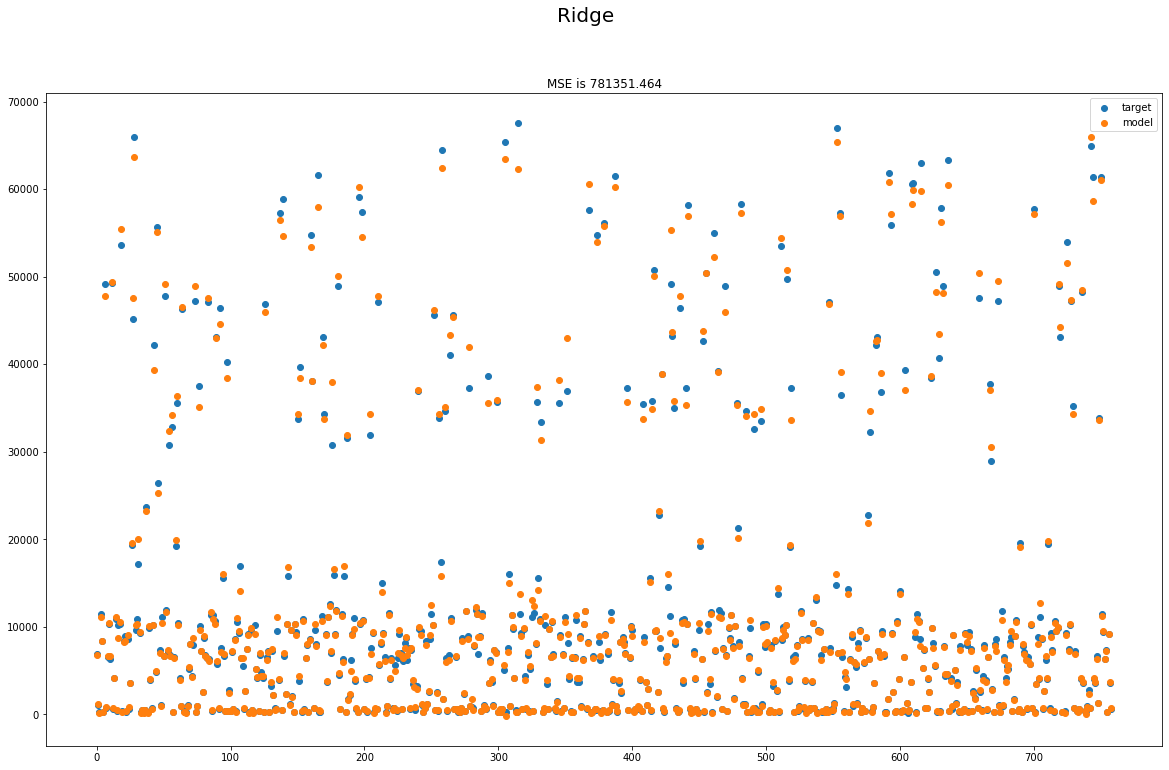

In [20]:
visualize(r_pred, test_y, "Ridge")

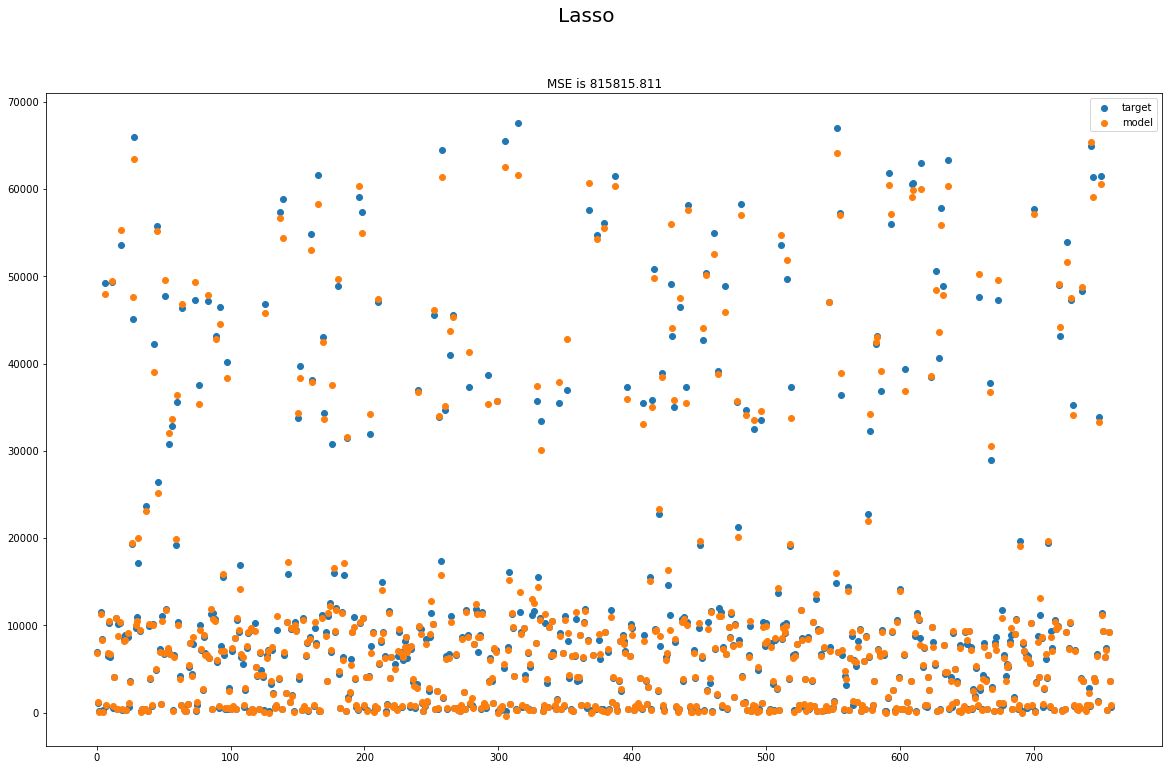

In [21]:
visualize(l_pred, test_y, "Lasso")


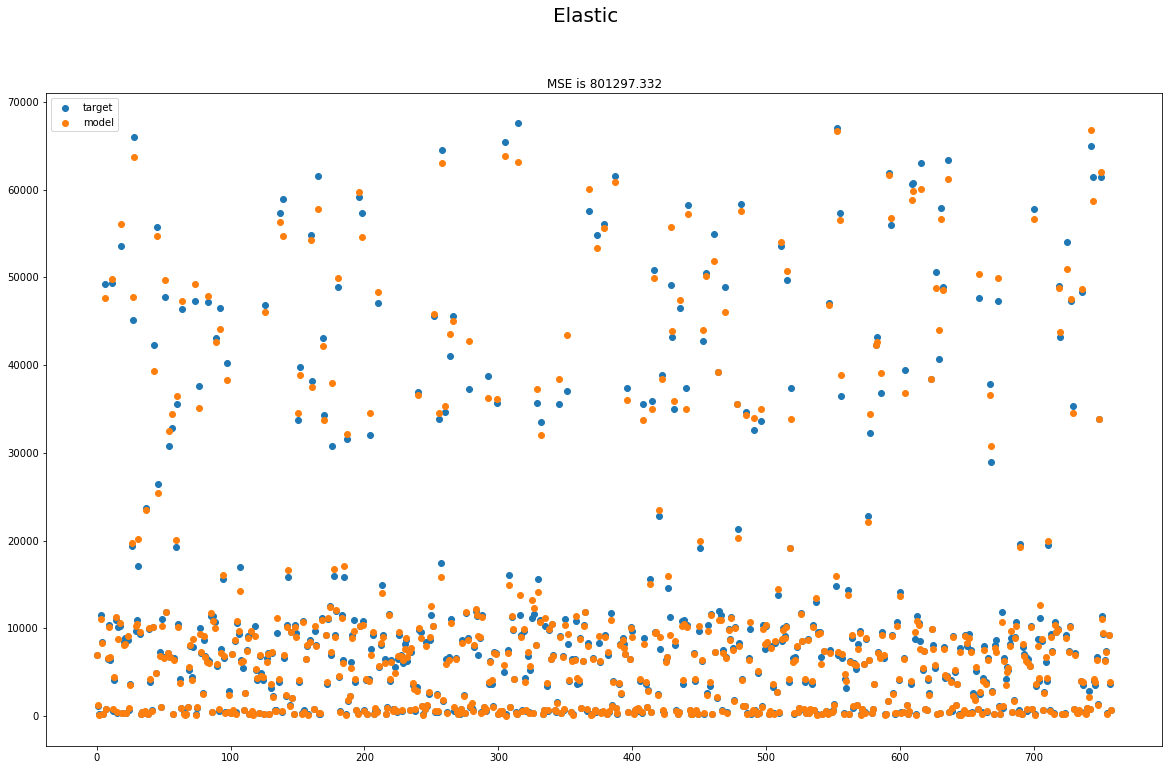

In [22]:
visualize(e_pred, test_y, "Elastic")

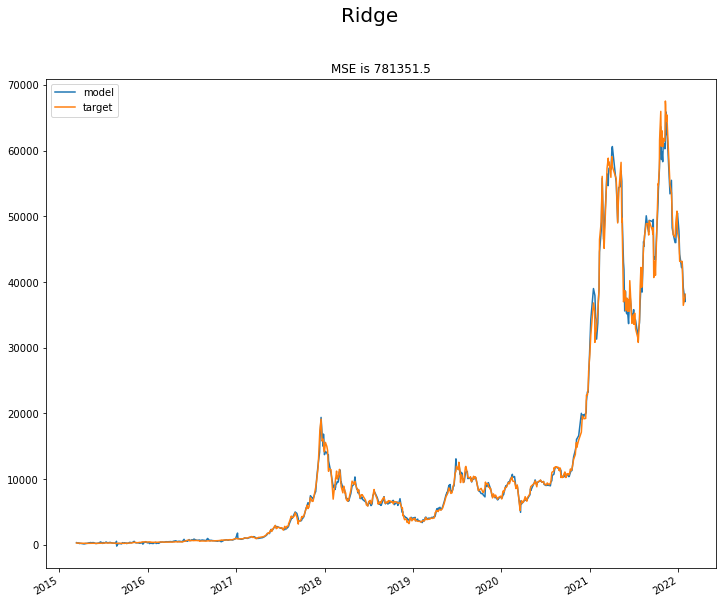

In [23]:
eval_model.visualize_plot(r_pred, test_y, "Ridge")


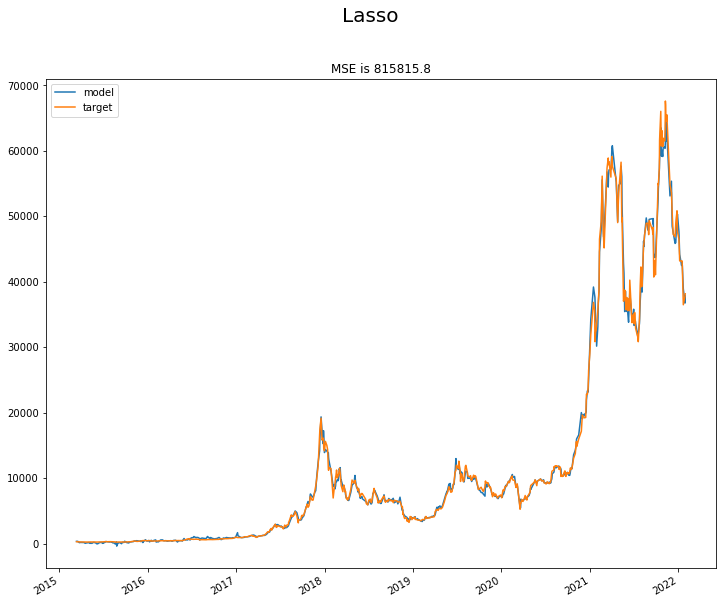

In [24]:
eval_model.visualize_plot(l_pred, test_y, "Lasso")


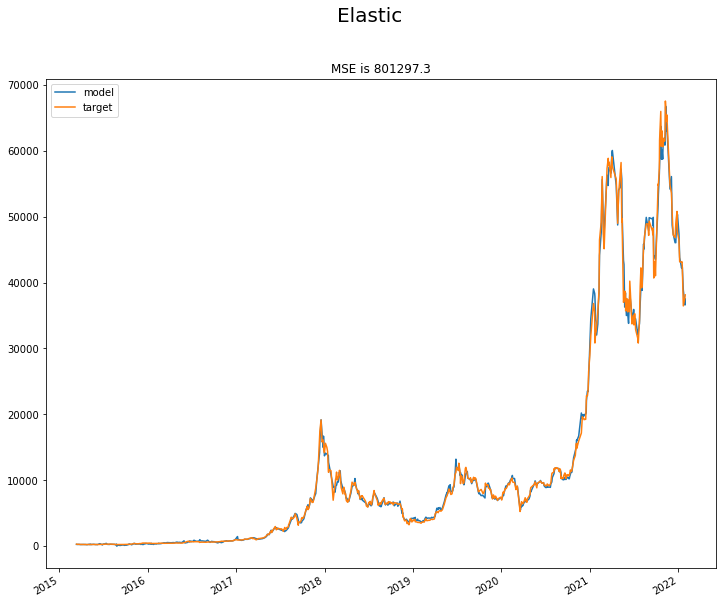

In [25]:
eval_model.visualize_plot(e_pred, test_y, "Elastic")


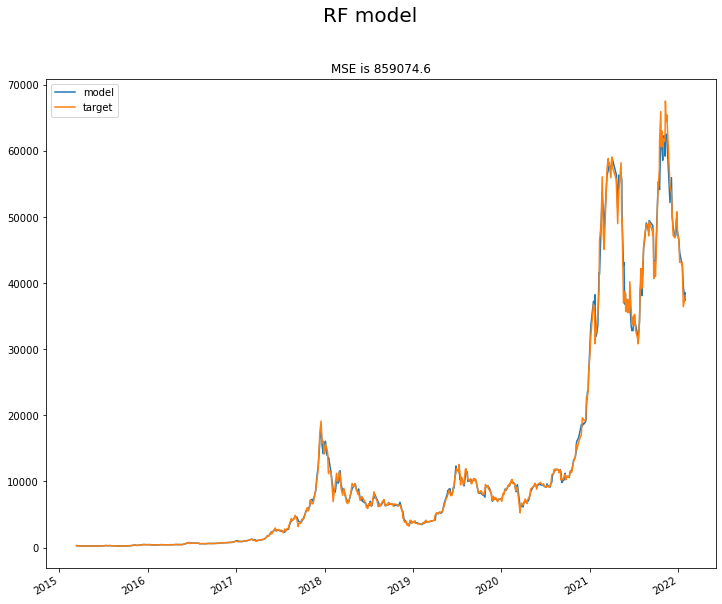

In [26]:
eval_model.visualize_plot(rf_pred, test_y, "RF model")

근래 존재하던 100거래일 동안의 모델의 퍼포먼스를 살펴보자
* 100일 간의 데이터는 학습하지 않은 데이터이다.

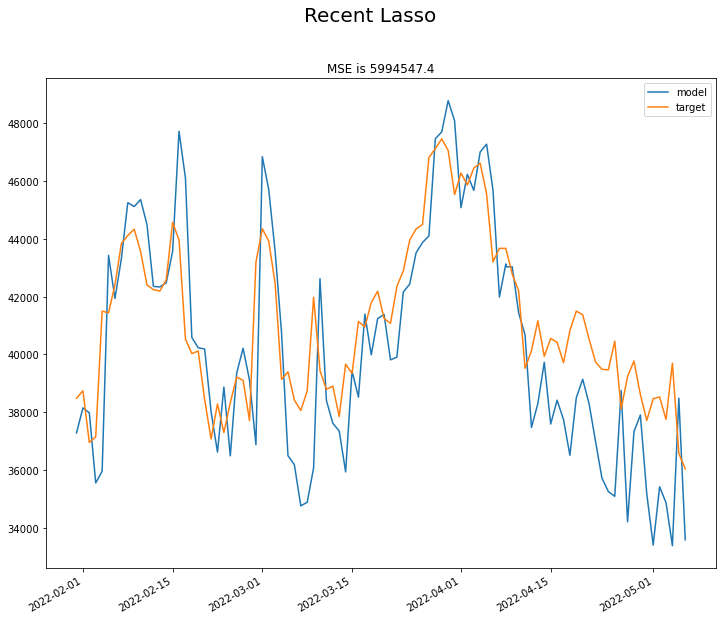

In [27]:
test_x = test_df.drop('BTC_Price',axis=1).iloc[:-1]
test_y = test_df['BTC_Price'].iloc[1:]
l_test_pred = lasso_model.predict(test_x)
eval_model.visualize_plot(l_test_pred, test_y, name="Recent Lasso")

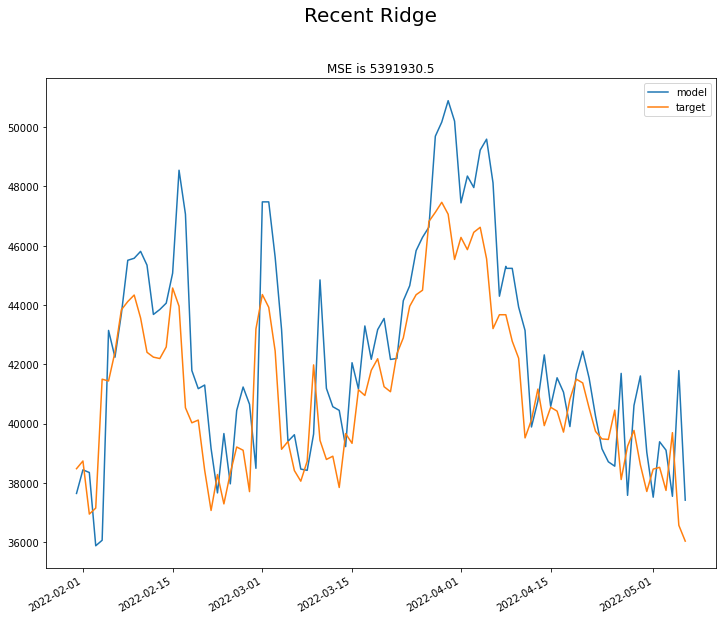

In [28]:
r_test_pred = ridge_model.predict(test_x)
eval_model.visualize_plot(r_test_pred, test_y, name="Recent Ridge")


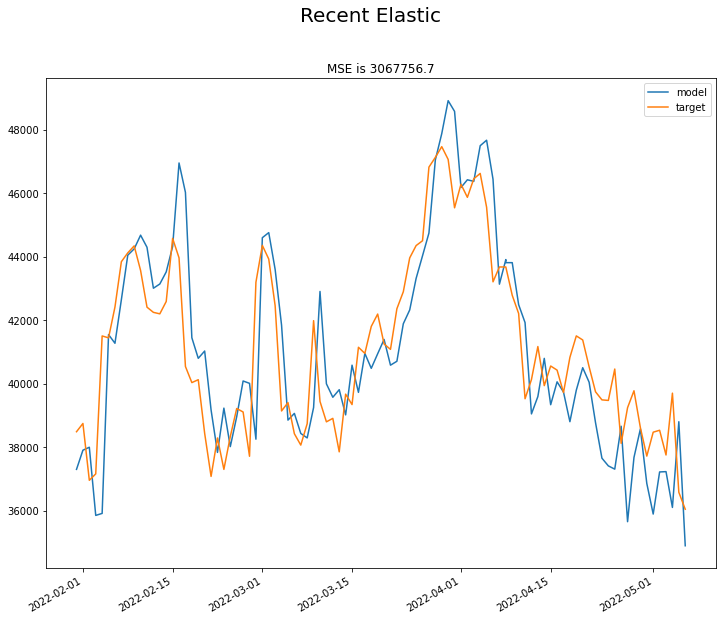

In [29]:
e_test_pred = elastic_model.predict(test_x)
eval_model.visualize_plot(e_test_pred, test_y, name="Recent Elastic")


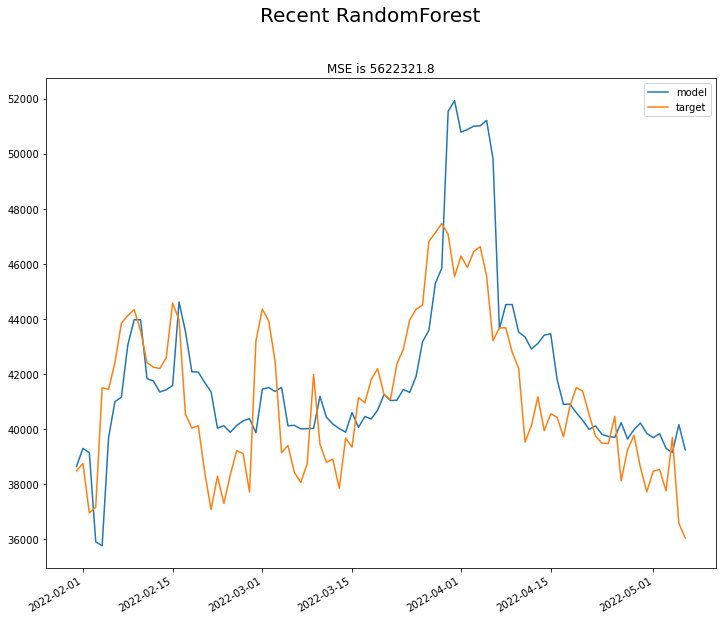

In [30]:
rf_test_pred = rf_model.predict(test_x)
eval_model.visualize_plot(rf_test_pred, test_y, name="Recent RandomForest")


In [35]:
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
tscv = TimeSeriesSplit(n_splits=20)
train_X = df_merged.drop(['BTC_Price'], axis=1).iloc[1:]
train_y = df_merged['BTC_Price'].iloc[:-1]
cv_result = []
for m in [ridge_model, lasso_model, elastic_model]:
    result = []
    for i, (train_index, test_index) in enumerate(tscv.split(train_X)):
        X_train, X_test = train_X.iloc[train_index], train_X.iloc[test_index]
        y_train, y_test = train_y.iloc[train_index], train_y.iloc[test_index]
        model = m.fit(X_train, y_train)
        pred = model.predict(X_test)
        mae = mean_absolute_error(y_test, pred)
        mse = np.sqrt(mean_squared_error(y_test, pred))
        score = r2_score(y_test, pred)
        adj_score = 1 - (1 - r2_score(y_test, pred)) * (len(y_test) - 1) / (len(y_test) - X_test.shape[1] - 1)
        result.append([mae, mse, score, adj_score])
    cv_result.append(pd.DataFrame(data = result, columns=["mae","mse","score","ajd_score"]))

/Users/jin/opt/anaconda3/envs/py_3.8/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 588.9010911094774, tolerance: 205.83082189603044
  model = cd_fast.enet_coordinate_descent(
/Users/jin/opt/anaconda3/envs/py_3.8/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1516.8703355304788, tolerance: 628.1964814292949
  model = cd_fast.enet_coordinate_descent(
/Users/jin/opt/anaconda3/envs/py_3.8/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2390.91969987176, tolerance: 1370.7098643822053
  model = cd_fast.enet_coordinate_descent(
/Users/jin/opt/anaconda3/envs/py_3.8/lib/

In [36]:
cv_result[0] #ridge

,mae,mse,score,ajd_score
0,7.403193,10.644489,0.835011,0.818207
1,27.523897,31.869294,0.356907,0.291407
2,10.661513,14.662788,0.976410,0.974007
3,28.338624,36.685076,-0.166741,-0.285576
4,69.400150,84.329845,0.558263,0.513271
5,303.942435,480.433679,0.376793,0.313318
6,208.669409,266.401577,0.930761,0.923709
7,2989.556632,4269.936574,-0.280295,-0.410696
8,1501.939903,1697.280178,-0.769790,-0.950046
9,566.268070,623.160960,-0.407381,-0.550725


In [37]:
cv_result[1] #lasso

,mae,mse,score,ajd_score
0,6.342416,8.722711,0.889208,0.877924
1,37.046943,40.611139,-0.044286,-0.150648
2,33.969603,43.819271,0.789320,0.767861
3,45.116687,51.821442,-1.328170,-1.565298
4,39.399266,47.624401,0.859116,0.844767
5,181.961673,275.566251,0.794970,0.774087
6,155.749727,186.464031,0.966079,0.962624
7,1501.211621,1881.185709,0.751498,0.726187
8,1820.197853,1910.356468,-1.242040,-1.470396
9,416.518732,460.917437,0.230059,0.151639


In [38]:
cv_result[2] #elastic

,mae,mse,score,ajd_score
0,7.658834,11.429524,0.809778,0.790404
1,27.591572,31.688343,0.364189,0.299430
2,11.781971,15.230387,0.974548,0.971956
3,36.579823,45.509084,-0.795527,-0.978404
4,48.737013,60.859833,0.769929,0.746495
5,143.954361,204.788092,0.886767,0.875233
6,357.501995,460.745963,0.792890,0.771796
7,3237.398161,4078.626268,-0.168141,-0.287118
8,1588.205170,1749.004089,-0.879301,-1.070711
9,602.531298,668.303804,-0.618673,-0.783538


In [39]:
for name, cv in zip(["Ridge","Lasso","Elastic"], cv_result):
    print(f"{name}:\n {cv.mean()}")

Ridge:
 mae          1252.271616
mse          1605.813359
score           0.394905
ajd_score       0.333275
dtype: float64
Lasso:
 mae          1224.973451
mse          1580.221141
score           0.408020
ajd_score       0.347725
dtype: float64
Elastic:
 mae          1103.695508
mse          1368.107499
score           0.476346
ajd_score       0.423011
dtype: float64


엘라스틱 모델의 퍼포먼스가 가장 괜찮게 나왔다. </br>
새로운 자산을 추가하는 것이 그다지 큰 효과를 발휘하고 있지 않다는 생각이 든다.</br>
* 이는 아마 주식 데이터는 평일에만 열리게 되므로 주말 간의 데이터가 손실 된 것이 어느정도 기여를 하지 않나 싶다.

In [40]:
import joblib
joblib.dump(lasso_model, "Lasso_total.pkl")
joblib.dump(ridge_model, "Ridge_total.pkl")
joblib.dump(elastic_model, "Elastic_total.pkl")


['Elastic_total.pkl']